In [2]:
""" mostly plotting results for rocky planet evolution + topographies """

%matplotlib inline
import numpy as np
import parameters as p
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from collections.abc import Iterable
from scipy import interpolate
import pandas as pd
from IPython.display import display, Math
import random as rand
import terrestrialplanet as tp
import thermal as therm
import topography as top
import rheology as rh
import inputs as ins
from mpl_tools import colorize

# fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop

In [3]:
###### BUILD PLANETS IN BULK #####

def bulk_planets(N=1, name=None, mini=None, maxi=None, visc_type='Thi', t_eval=None,
                 T_m0=1750, T_c0=2250, D_l0=300e3, tf=4.5, **kwargs): 
    """varying single parameter 'name' between mini and maxi, use default values otherwise."""
    planets = []
    ii=0
    while ii<N:
        val = rand.uniform(mini, maxi)
        kwargs.update({name:val})
        pl = tp.TerrestrialPlanet(**kwargs)
        model_kwargs = dict(T_m0=T_m0, T_c0=T_c0, D_l0=D_l0, tf=tf, visc_type=visc_type) # model params
        pl = therm.solve(pl, t_eval=t_eval, **model_kwargs) # T_m, T_c, D_l
        pl.dyn_top_rms = top.dyn_topo(pl)    
        planets.append(pl)
        ii+=1
    return planets
def build_solarsystem(run_args=None):
    planets = []
    for ii, ident in enumerate(['Moon1', 'Mercury1', 'Mars1', 'Venus', 'Earth']):
        planet_kwargs = eval('ins.'+ident+'_in') 
        model_kwargs = eval('ins.'+ident+'_run')
        if run_args is not None:
            model_kwargs.update(run_args)
        pl = tp.TerrestrialPlanet(**planet_kwargs)
        pl = therm.solve(pl, **model_kwargs) # T_m, T_c, D_l
        pl.dyn_top_rms = top.dyn_topo(pl)   
        pl.sigma_interior = top.convective_stress(pl, where='interior') 
        pl.max_top = top.max_topo(pl)
        planets.append(pl)
    return planets
planets = build_solarsystem()

In [4]:
###### PLOTTING ######

def plot_output(pl, names, ncols=6, tspan=None, title=None, plots_save=False, verbose=True,
                compare_dir=None, fig_path='figs/', labelsize=15, legsize=10, lw=1, ls='-', 
                print_tf=False, col=None, colorbar=False, legend=True,
                ident=None, fig=None, axes=None, label=None, **kwargs):

    if ident is None:
        ident = pl.ident
    if col is None:
        col = 'k'
    
    t = pl.t # time points of ode solutions in s
    
    nrows = int(np.ceil(len(names)/ncols))
    if (fig is None) and (axes is None):
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    if tspan is None:
        tspan = (0, t[-1]*1e-9/p.years2sec)
    out_vars = list(names.keys())
    ylabels = list(names.values()) # tuple (ylabel, yscale)
    if label is None:
        label = 'this work'
    for n, par in enumerate(out_vars):
        ax = axes.flatten()[n]
        y = eval('pl.'+par)
        if np.size(y)==1:
            y = [y]*len(t)
        try:
            yl = str(ylabels[n][0])
            if par=='eta_m': # always log scale for viscosity
                y = np.log10(y)
            plot_one(ax, t*1e-9/p.years2sec, y*ylabels[n][1], xlabel='', ylabel=yl, ls=ls, label=label, c=col)
            if compare_dir is not None: 
                try: # if data exists to benchmark this param
                    df = pd.read_csv(compare_dir+'/'+par+'.csv', header=None, names=['time', 'value'],
                                    index_col=False)
                    plot_one(ax, df['time'], df['value'], 
                             '', yl, c='r', labelsize=labelsize, legsize=legsize, lw=lw, ls=ls, 
                             label=compare_dir)

                except IOError:
                    #print('file', str(compare_dir+'/'+par+'.csv'), 'not found')
                    pass
            if par=='urey' and print_tf: # print final value
                ii = np.where(t*1e-9/p.years2sec<=tspan[-1])
                ax.annotate('%.2f'%(y[ii][-1]), xy=(tspan[-1], y[ii][-1]), fontsize=legsize, 
                            color='xkcd:bright purple',
                            textcoords="axes fraction", xytext=(1.05, 0.3),
                        #ha='center', va='bottom',
                            arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.1",
                                           ec='xkcd:bright purple'))
            ax.set_xlim(tspan)
            if legend:
                ax.legend(frameon=False, fontsize=legsize)
        except ValueError as e:
            print('could\'t plot', par)
            print(e)
    
    while n+1 < ncols*nrows :
        fig.delaxes(axes.flatten()[n+1])
        n += 1 # hide unused axes
        
    plot_setxlabel(axes, 'Age (Gyr)', 'all')
    if title is None:
        title = pl.ident
    axes[0][0].set_title(title, fontsize=labelsize)
    

    
    
    plt.tight_layout()
    if plots_save:
        plt.savefig(fig_path+ident+'.pdf', bbox_inches='tight') 
    if verbose:
        print('\n        n timesteps =', len(t))
        print('$t_f$ =', t[-1]*p.sec2Gyr, 'Gyr')
        print(r'$R_p$ =', '%.2f'%(pl.R_p/p.R_E), 'R_E =', '%.2f'%(pl.R_p*1e-3), 'km')
#         print(r'$R_c$ =', '%.2f'%(kwargs['CRF']*kwargs['R_p']*1e-3), 'km')
        print('M_c', '%.2e'%pl.M_c, 'kg')   
        print(r'$M_{m+lid}$ =', '%.2e'%(pl.M_m), 'kg')
        print(r'$g_{sfc}$ =', '%.2f'%pl.g_sfc, 'm s^-2')
        print(r'$g_{cmb}$ =', '%.2f'%pl.g_cmb, 'm s^-2')
        print(r'$\kappa_m$', '%.6f'%pl.kappa_m, 'm^2 s^-1')
        print(r'CRF =', '%.2f'%pl.CRF)
        print(r'$h_0$ =', '%.2f'%(pl.h_rad_m[0]*1e12), 'pW kg^-1')
        print(r'$h_{4.5}$ =', '%.2f'%(pl.h_rad_m[-1]*1e12), 'pW kg^-1')
#         print(r'$H_0$ =', '%.2f'%(H_rad_m[0] + H_rad_lid[0]), 'TW')
#         print(r'$H_{4.5}$ =', '%.2f'%(H_rad_m[-1] + H_rad_lid[-1]), 'TW')
        print(r'Urey ratio @ $t_f$ =', '%.2f'%pl.urey[-1])
        print('q_sfc(t=0)', '%.2f'%(pl.q_sfc[0]*1e3), 'mW m^-3')
    return fig, axes

def snaps(pl, plot_snapshots=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s
    try:
        n_col = len(plot_snapshots)
    except:
        n_col = 1
    fig2, axes2 = plt.subplots(1, n_col,figsize=(3*n_col,5))
    for iax, tx in enumerate(plot_snapshots): # tx is the time value u want nearest
        ii = min(enumerate(t), key=lambda x: abs(tx - x[1]*p.sec2Gyr))[0]
        plot_structure(ax=axes2[iax], t=t[ii], T_m=pl.T_m[ii], T_c=pl.T_c[ii], T_s=pl.T_s,
                       T_l=pl.T_l[ii], R_l=pl.R_l[ii], R_p=pl.R_p, R_c=pl.R_c, h_rad_m=pl.h_rad_m[ii],
                       d_lbl = pl.TBL_c[ii], d_ubl = pl.TBL_u[ii], q_ubl = pl.q_ubl[ii], a0=pl.a0[ii],
                       k_m=pl.k_m, legsize=10, **kwargs)
    plt.tight_layout()
    if plots_save:
        fig2.savefig(fig_path+pl.ident+'_profiles.pdf', bbox_inches='tight') 
    return fig2, axes2

def plot_structure(ax=None, t=None, T_m=None, T_c=None, R_p=None, R_l=None, R_c=None, T_l=None, 
                   T_s=None, h_rad_m=None, d_lbl=None, d_ubl=None, q_ubl=None, a0=None, k_m=None,
                   labelsize=16, legsize=14, Tlid_ini=None, **kwargs):
    """ plot temp structure (for a given time) """
    r_c = np.linspace(0, R_c*1e-3)
    r_lbl = np.linspace(R_c*1e-3, (R_c+d_lbl)*(1e-3))
    r_m = np.linspace((R_c+d_lbl)*1e-3, (R_l-d_ubl)*1e-3) # radius for mantle in km
    r_ubl = np.linspace((R_l-d_ubl)*1e-3, (R_l)*1e-3)
    r_l = np.linspace(R_l*1e-3, R_p*1e-3) # radius for lid
    T_cond = therm.sph_conduction(r_l*1e3, a0=a0, T_l=T_l, R_p=R_p, R_l=R_l, T_s=T_s, k_m=k_m, **kwargs)
    q = therm.sph_flux(r_l*1e3, a0=a0, T_l=T_l, T_s=T_s, R_p=R_p, R_l=R_l, k_m=k_m, **kwargs)
    if Tlid_ini=='linear':
        T_cond = therm.sph_conduction(r_l*1e3, a0=0, T_l=T_l, R_p=R_p, R_l=R_l, T_s=T_s, k_m=k_m,**kwargs)
        q = therm.sph_flux(r_l*1e3, a0=0, T_l=T_l, T_s=T_s, R_p=R_p, R_l=R_l, k_m=k_m,**kwargs)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
    ax.axhline(y=R_l*1e-3, ls='--', lw=1, c='xkcd:bluish purple')
    ax.axhline(y=R_c*1e-3, ls='--', lw=1, c='xkcd:clay')

    ax.plot(T_cond, r_l, c='xkcd:bluish purple')
    ax.plot(T_l + q_ubl/k_m*(R_l - r_ubl*1e3), r_ubl, c='xkcd:greenish')
    ax.plot([T_m]*len(r_m), r_m, c='xkcd:greenish')
    ax.plot([T_m, T_c], [(R_c+d_lbl)*1e-3, R_c*1e-3], c='xkcd:greenish', marker = None)
    ax.plot([T_c]*len(r_c), r_c, c='xkcd:clay')
        
    ax.set_ylabel('Radius (km)', fontsize=labelsize)
    ax.set_xlabel('Temperature (K)', fontsize=labelsize)
    ax.set_ylim([0, R_p*1e-3])
#     #ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(T_cond[-1], 0, 'Core', ha='left', va='bottom', fontsize=legsize, c='xkcd:clay')
#     #ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(T_cond[-1], R_c*1e-3, 'Convecting region', ha='left', va='bottom', fontsize=legsize, c='xkcd:greenish')
    ax.text(T_cond[-1], R_l*1e-3, 'Lid', ha='left', va='bottom', fontsize=legsize, c='xkcd:bluish purple')
    
    ax2 = ax.twiny()
    ax2.set_xlabel('Flux, steady-state (mW m$^{-2}$)', color='xkcd:grey')  
    ax2.plot(q*1e3, r_l, color='xkcd:grey')
    ax2.plot(q_ubl*1e3, r_ubl[0], marker='o', color='xkcd:grey')
    ax2.annotate('$q_{ubl}$', (q_ubl*1e3, r_ubl[-1]), color='xkcd:grey', fontsize=12, ha="left", va="top")
    ax2.tick_params(axis='x', labelcolor='xkcd:grey')
    
    ax.set_title(('%.1f'%(t*1e-9/p.years2sec))+' Gyr', fontsize=labelsize)

    return ax

def interp_benchmark(path, yscale=1):
    df = pd.read_csv(path, header=None, names=['time', 'value'], index_col=False) 
    f = interpolate.interp1d(np.array(df['time']), np.array(df['value'])*yscale, kind='linear')
    times = df['time'] # in Gyr 
    return np.array(times), f

def plot_qsfc_error(pl, ax3=None, compare_dir=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    """ sanity check on q_sfc """
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s
    if ax3 is None:
        fig3, ax3 = plt.subplots(1, 1, figsize=(5,5))
        
    t_D_l, f_D_l_interp = interp_benchmark(path=compare_dir+'/D_l.csv', yscale=1e3) # in Gyr, m
    temp = t*1e-9/p.years2sec # in Gyr
    
    try:
        t_T_l, f_T_l_interp = interp_benchmark(path=compare_dir+'/T_l.csv')# in Gyr, K
        iii = np.where((temp>=t_T_l.min()) & (temp<=t_T_l.max()))
        times0 = temp[iii] # time points of ODE solver subset to interpolation range
        T_l_interp = f_T_l_interp(times0) # published plot interpolated to model times, in K
    except FileNotFoundError as e:
        t_T_l, f_T_avg_interp = interp_benchmark(path=compare_dir+'/T_avg.csv') # in Gyr, K
        iii = np.where((temp>=t_T_l.min()) & (temp<=t_T_l.max()))
        times0 = temp[iii] # time points of ODE solver subset to interpolation range
        T_avg_interp = f_T_avg_interp(times0) # published plot interpolated to model times, in K
        T_l_interp = Tl_from_Tmean(R_l=pl.R_l[iii], T_avg=T_avg_interp, a0=pl.a0[iii], **kwargs)
    

    D_l_interp = f_D_l_interp(times0) # published plot interpolated to model times, in m
    R_l_interp = pl.R_p - D_l_interp
    q_sfc_interp = therm.sph_flux(pl.R_p, a0=pl.a0[iii], T_l=T_l_interp, T_s=pl.T_s, R_l=R_l_interp, 
                                  R_p=pl.R_p, k_m=pl.k_m, **kwargs) # sfc flux in W m^-2

    ax3.plot(times0, pl.q_sfc[iii]*1e3, c='xkcd:black', label='this work')
    ax3.plot(times0, q_sfc_interp*1e3, c='xkcd:blue', label='Thiriet interp')
    df = pd.read_csv(compare_dir+'/q_sfc.csv', header=None, names=['time', 'value'],
                     index_col=False) # in Gyr, mW m^-3
    ax3.plot(df['time'], df['value'], c='xkcd:red', label='Thiriet digitised')
    ax3.legend(frameon=False, fontsize=14)
    ax3.set_xlabel('Time (Gyr)', fontsize=16)
    ax3.set_ylabel('$q_{sfc}$ (mW m$^{-2}$)', fontsize=16)

#     plt.tight_layout()

    fig0, ax0 = plt.subplots(1,1,  figsize=(4,4))
    ax0.plot(times0, pl.q_sfc[iii]*1e3 - q_sfc_interp*1e3, c='xkcd:grey')
    ax0.set_xlabel('Time (Gyr)', fontsize=14)
    ax0.set_ylabel('$\Delta q_{sfc}$ (mW m$^{-2}$)', fontsize=14)
    ax0.set_title('Mean error: $\pm$'+'%.2f'%np.mean(np.absolute(pl.q_sfc[iii]*1e3 - q_sfc_interp*1e3))+' mW m$^{-2}$', 
                  fontsize=14)
    plt.tight_layout()
    if plots_save:
        fig3.savefig(fig_path+pl.ident+'_test_qsfc.pdf')
        fig0.savefig(fig_path+pl.ident+'_q_error.pdf')

def plot_Tavg(pl, ax3=None, compare_dir=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    """ sanity check on T_avg """
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s

    if ax3 is None:
        fig3, ax3 = plt.subplots(1, 1, figsize=(5,5))
        
    # plot your T_avg calculation but using interpolated published D_l    
    t_D_l, f_D_l_interp = interp_benchmark(path=compare_dir+'/D_l.csv', yscale=1e3) # in Gyr, m
    
    # select model time points in interpolation range
    temp = t*1e-9/p.years2sec # in Gyr
    iii = np.where((temp>=t_D_l.min()) & (temp<=t_D_l.max()))
    times0 = temp[iii] # time points of ODE solver subset to interpolation range
    D_l_interp = f_D_l_interp(times0) # published D_l at model time points in m
    R_l_interp = pl.R_p - D_l_interp # m
    
    T_avg_interp = therm.T_mean(T_m=pl.T_m[iii], T_l=pl.T_l[iii], R_p=pl.R_p, R_l=R_l_interp, 
                                R_c=pl.R_c, a0=pl.a0[iii], T_s=pl.T_s, k_m=pl.k_m, **kwargs)
    ax3.plot(times0, pl.T_avg[iii], c='xkcd:black', label='this work')
    ax3.plot(times0, T_avg_interp, c='xkcd:blue', label='this work with Thiriet D_l')
    df = pd.read_csv(compare_dir+'/T_avg.csv', header=None, names=['time', 'value'],
                     index_col=False) # in Gyr, mW m^-3
    ax3.plot(df['time'], df['value'], c='xkcd:red', label='Thiriet digitised')
    ax3.legend(frameon=False, fontsize=14)
    ax3.set_xlabel('Time (Gyr)', fontsize=16)
    ax3.set_ylabel('$T_{avg}$ (K)', fontsize=16)  
    ax3.set_title('blue should match red')
    
    plt.tight_layout()
    if plots_save:
        fig3.savefig(fig_path+pl.ident+'_test_Tavg.pdf')
        
def plot_one(ax, x, y, xlabel, ylabel, labelsize=15, legsize=16, lw=1, ls='-', marker=None, 
             ms=5, c='k', text=None, xticks=True, ylim=None, label=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms, label=label)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

def plot_setxlabel(axes, label, style, labelsize=15):
    try:
        ny, nx = np.shape(axes) # assume 2D
        for ii, ax in enumerate(axes):
            for jj, a in enumerate(ax):
                if (style=='all') or ((style=='bottom') and (jj==ny-1)):
                    a.set_xlabel(label, fontsize=labelsize)
                if (style=='bottom') and (jj<ny-1):
                    a.set_xticks([])
    except ValueError: # 1D
        try:
            for jj, a in enumerate(axes):
                if (style=='all') or ((style=='bottom') and (jj==ny-1)):
                    a.set_xlabel(label, fontsize=labelsize)
                if (style=='bottom') and (jj<ny-1):
                    a.set_xticks([])
        except TypeError: # single
            axes.set_xlabel(label, fontsize=labelsize)
                
def Tl_from_Tmean(R_c=None, R_l=None, R_p=None, T_avg=None, T_s=None, a0=None, k_m=None, **kwargs):
    """solved for T_l using sympy"""
    return (k_m*(4*R_l**4 - 4*R_l**3*R_p - 3*R_l**2*R_p**2 + 2*R_l*R_p**3 + R_p**4)*(-60*Ea*R_c**6*k_m + 60*Ea*R_c**3*R_l**3*k_m + 30*Ea*R_c**3*R_l**2*R_p*k_m + 30*Ea*R_c**3*R_l*R_p**2*k_m - 30*Ea*R_l**5*R_p*k_m - 30*Ea*R_l**4*R_p**2*k_m + 120*R_b*R_c**3*R_l**3*T_avg*a_rh*k_m - 60*R_b*R_c**3*R_l**2*R_p*T_avg*a_rh*k_m - 60*R_b*R_c**3*R_l*R_p**2*T_avg*a_rh*k_m - 8*R_b*R_l**8*a0*a_rh + 14*R_b*R_l**7*R_p*a0*a_rh + 9*R_b*R_l**6*R_p**2*a0*a_rh - 20*R_b*R_l**5*R_p**3*a0*a_rh - 60*R_b*R_l**5*R_p*T_s*a_rh*k_m - 10*R_b*R_l**4*R_p**4*a0*a_rh - 30*R_b*R_l**4*R_p**2*T_s*a_rh*k_m + 18*R_b*R_l**3*R_p**5*a0*a_rh - 120*R_b*R_l**3*R_p**3*T_avg*a_rh*k_m + 180*R_b*R_l**3*R_p**3*T_s*a_rh*k_m + R_b*R_l**2*R_p**6*a0*a_rh + 60*R_b*R_l**2*R_p**4*T_avg*a_rh*k_m - 30*R_b*R_l**2*R_p**4*T_s*a_rh*k_m - 4*R_b*R_l*R_p**7*a0*a_rh + 60*R_b*R_l*R_p**5*T_avg*a_rh*k_m - 60*R_b*R_l*R_p**5*T_s*a_rh*k_m) - 2*sqrt(15)*sqrt(Ea*k_m**3*(60*Ea*R_c**6*k_m - 60*Ea*R_c**3*R_l**2*R_p*k_m - 60*Ea*R_c**3*R_l*R_p**2*k_m + 15*Ea*R_l**4*R_p**2*k_m + 30*Ea*R_l**3*R_p**3*k_m + 15*Ea*R_l**2*R_p**4*k_m - 240*R_b*R_c**3*R_l**3*T_avg*a_rh*k_m + 120*R_b*R_c**3*R_l**2*R_p*T_avg*a_rh*k_m + 120*R_b*R_c**3*R_l*R_p**2*T_avg*a_rh*k_m + 16*R_b*R_l**8*a0*a_rh - 28*R_b*R_l**7*R_p*a0*a_rh - 18*R_b*R_l**6*R_p**2*a0*a_rh + 40*R_b*R_l**5*R_p**3*a0*a_rh + 120*R_b*R_l**5*R_p*T_s*a_rh*k_m + 20*R_b*R_l**4*R_p**4*a0*a_rh + 60*R_b*R_l**4*R_p**2*T_s*a_rh*k_m - 36*R_b*R_l**3*R_p**5*a0*a_rh + 240*R_b*R_l**3*R_p**3*T_avg*a_rh*k_m - 360*R_b*R_l**3*R_p**3*T_s*a_rh*k_m - 2*R_b*R_l**2*R_p**6*a0*a_rh - 120*R_b*R_l**2*R_p**4*T_avg*a_rh*k_m + 60*R_b*R_l**2*R_p**4*T_s*a_rh*k_m + 8*R_b*R_l*R_p**7*a0*a_rh - 120*R_b*R_l*R_p**5*T_avg*a_rh*k_m + 120*R_b*R_l*R_p**5*T_s*a_rh*k_m))*(R_c - R_l)*(R_l - R_p)**2*(2*R_l + R_p)**2*(R_c**2 + R_c*R_l + R_l**2))/(30*R_b*R_l**2*a_rh*k_m**2*(R_l - R_p)**2*(2*R_l + R_p)**2*(4*R_l**4 - 4*R_l**3*R_p - 3*R_l**2*R_p**2 + 2*R_l*R_p**3 + R_p**4))

def plot_vs_x(scplanets=None, lplanets=None, xname=None, ynames=None, planets2=None, fig=None, axes=None, labels=False, labelsize=15, 
              plots_save=False, legsize=10, c=None, s=30, ls='-', lw=1, cmap='rainbow', marker='o', colorbar=False,
              zorder_l=None, zorder_sc=None, **kwargs):
        # for a list of planets, plot some parameter on the y axis vs. parameter x
    if (c is None) and (scplanets is not None):
        c = np.arange(len(scplanets))
#         colour = cm.get_cmap(cmap)
#         norm = colors.Normalize(vmin=0, vmax=len(planets))
    nax = len(ynames)
    if axes is None:
        fig, axes = plt.subplots(1, nax, figsize=(5*nax, 4))
    
    xparam = list(xname.keys())[0]
    xlabels = list(xname.values())[0]
    yparam = list(ynames.keys())
    ylabels = list(ynames.values()) # tuple (ylabel, yscale)
    ii=0
    while ii < nax:
        try:
            ax = axes[ii]
        except TypeError: # single ax
            ax = axes
        if scplanets is not None:
            x = []
            y = []
            for ip, pl in enumerate(scplanets): # planets to plot as scatter
                data_x = eval('pl.'+xparam)*xlabels[1]
                if isinstance(data_x, Iterable):
                    data_x = data_x[-1] # get final value
                x.append(data_x)
                data_y = eval('pl.'+yparam[ii])*ylabels[ii][1]
                if isinstance(data_y, Iterable):
                    data_y = data_y[-1] # get final value
                y.append(data_y) 
                if labels:
                    ax.annotate(xy=(data_x,data_y), s=pl.ident[0:2], fontsize=legsize)
            sc = ax.scatter(x, y, c=c, s=s, marker=marker, cmap=cmap, zorder=zorder_sc)
            if colorbar and (ii==0):
                plt.colorbar(sc)
        if lplanets is not None:
            x = []
            y = []
            for ip, pl in enumerate(lplanets): # planets to plot as line
                data_x = eval('pl.'+xparam)*xlabels[1]
                if isinstance(data_x, Iterable):
                    data_x = data_x[-1]
                x.append(data_x)
                data_y = eval('pl.'+yparam[ii])*ylabels[ii][1]
                if isinstance(data_y, Iterable):
                    data_y = data_y[-1] # get final value
                y.append(data_y) # get final value
            # sort
            x, y = zip(*sorted(zip(x, y)))
            ax.plot(x, y, ls=ls, c='k', lw=lw, zorder=zorder_l)
        ax.set_ylabel(ylabels[ii][0], fontsize=labelsize)
        # log scale for viscosity
        if (yparam[ii] is 'eta_m') or (yparam[ii] is 'nu_m'):
            ax.set_yscale('log')
        if (xparam is 'eta_m') or (xparam is 'nu_m') or (xparam is 'eta_0'):
            ax.set_xscale('log')
        ii+=1
    plot_setxlabel(axes, xlabels[0], 'all', labelsize=labelsize)
    plt.tight_layout()
    if plots_save:
        plt.savefig(fig_path+'scatter_'+xparam+'.pdf', bbox_inches='tight') 
    return fig, axes

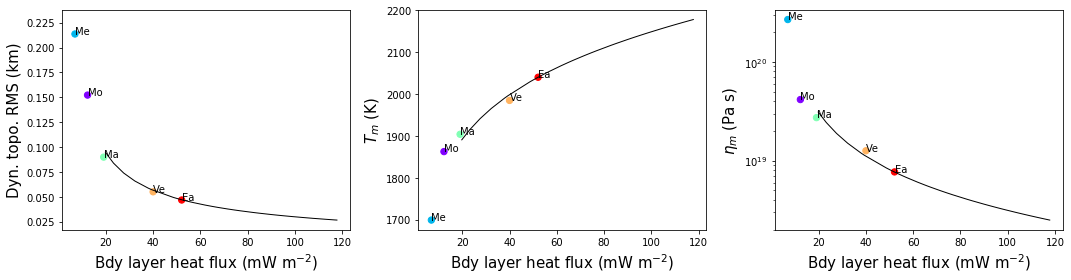

In [12]:
##### plot q_bl tradeoffs ######

# planets = build_solarsystem()
defaults = {'Ra_crit_u':450, 'c_m': 1142, 'k_lm':4, 'alpha_m':2.5e-5, 
            'h_rh':2.07e-3, 'a_rh':2.54, 
           }

save=False
ynames = {'dyn_top_rms':('Dyn. topo. RMS (km)', 1e-3),
         'T_m':('$T_m$ (K)',1),
         'eta_m':('$\eta_m$ (Pa s)',1),
        # 'D_l':('$D_l$ (km)', 1e-3),
        }
xname = {'q_ubl':('Bdy layer heat flux (mW m$^{-2}$)', 1e3)}
moreplanets = bulk_planets(N=50, name='M_p', mini=0.05*p.M_E, maxi=6*p.M_E, visc_type='KW', **defaults)
fig, axes = plot_vs_x(scplanets=planets, lplanets=moreplanets, xname=xname, ynames=ynames, 
                      labels=True, s=40, plots_save=True)

# add data 
q_data = [] # in mW/m2
h_data = [] # in km
labels = ['']

for ii in range(len(q_data)):
    axes[0].scatter(q_data[ii], h_data[ii], marker=markers[ii], c='k')
    axes[0].annotate(xy=(q_data[ii],h_data[ii]), s=labels[ii])
fig.savefig('q_scatter.png', bbox_inches='tight')

/home/claire/Works/exo-top/thermal.py:88: RuntimeWarning: invalid value encountered in double_scalars
  return (R_l - R_c) * (Ra_crit/Ra_rh)**beta
/home/claire/Works/exo-top/thermal.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  return (R_l - R_c) * (Ra_crit/Ra_rh)**beta
/home/claire/Works/exo-top/topography.py:17: RuntimeWarning: invalid value encountered in sqrt
  RMS = C*rho_m/(rho_m-rho_w) * ((alpha_m*F*eta_m*kappa_m)/(rho_m*g_sfc*k_m))**(1/2) # eqn 33 Parsons & Daly


ValueError: 'c' argument has 50 elements, which is not acceptable for use with 'x' with size 23, 'y' with size 23.

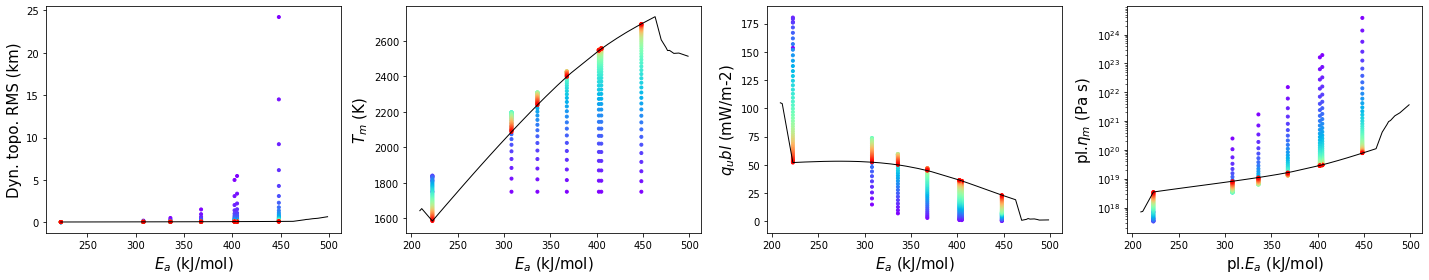

In [16]:
##### plot visc tradeoffs ######

# # planets = build_solarsystem({'visc_type':'KW'})
defaults = {'Ra_crit_u':450, 'c_m': 1142, 'k_lm':4, 'alpha_m':2.5e-5, 
            'h_rh':2.07e-3, 'a_rh':2.54, 
           }

save=False
ynames = {'dyn_top_rms':('Dyn. topo. RMS (km)', 1e-3),
         'T_m':('$T_m$ (K)',1),
         'q_ubl':('$q_ubl$ (mW/m-2)',1e3),
        'eta_m':('$\eta_m$ (Pa s)',1),
        }
xname = {'Ea':('$E_a$ (kJ/mol)',1e-3)}
zrange = np.linspace(200e3, 500e3, num=50)
t_eval = np.linspace(0, 4.5e9*p.years2sec, num=50)
moreplanets = bulk_planets(N=50, name='Ea', mini=zrange[0], maxi=zrange[-1], t_eval=t_eval, visc_type='KW', 
                           **defaults)
fig, axes = plot_vs_x(lplanets=moreplanets, xname=xname, ynames=ynames, 
                      s=40, plots_save=False, zorder_l=100)


col = colorize(t_eval, cmap='rainbow')[0]
for j, pl in enumerate(moreplanets):
    for k, ax in enumerate(axes):
#         if j==0:
#             print('ax', k)
        x = eval('pl.'+list(xname.keys())[0])*list(xname.values())[0][1]
        yyy =  eval('pl.'+list(ynames.keys())[k])*list(ynames.values())[k][1]
        ax.scatter([x]*len(yyy), yyy, c=t_eval, vmin=t_eval.min(), vmax=t_eval.max(), marker='.', cmap='rainbow')
#         for kk, y in enumerate(yyy):
# #             if j==0:
# #                 print('kk:', kk, '; x, y', x, y)
#             ax.plot(x, y, c = "k", marker='o')
    
    if j==0:
        ax.set_xlabel('pl.'+list(xname.values())[0][0])
        ax.set_ylabel('pl.'+list(ynames.values())[k][0])

    # 29 march: trying to plot Ea vs visc, T with colours different time steps to see how Ea affects things

In [5]:
def q_bl_analytic(T_m=2000, pl=None, eta_0=1e21, Ea=300e3,  a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
                  k_m=4, alpha_m=2e-5, kappa_m=1e-6, P=0, V_rh=6e-6, mu=80e9, A_rh=8.7e15, T_c=None,
                  h_rh=10**-2, B_rh=0.5e-9, m_rh=2.5, visc_type='KW', Ra_crit=450, **kwargs):
#     print('\nanalytic')
    if pl is not None:
        Ea = pl.Ea
        V_rh = pl.V_rh
        mu = pl.mu
        A_rh = pl.A_rh
        B_rh = pl.B_rh
        m_rh = pl.m_rh
        h_rh = pl.h_rh
        a_rh = pl.a_rh
        g_sfc = pl.g_sfc
        rho_m = pl.rho_m
        k_m = pl.k_m
        alpha_m = pl.alpha_m
        kappa_m = pl.kappa_m
        eta_0 = pl.eta_0
        T_0 = pl.T_ref
        V_rh = pl.V_rh
        Ra_crit = pl.Ra_crit_u    
    if visc_type is 'Thi':
        return p.R_b*T_m**2*a_rh*k_m*(p.R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/p.R_b)/(Ea*eta_0*kappa_m))**0.333333333333333/Ea
    elif visc_type is 'KW':
        h=1
        T_l = T_m - a_rh*(p.R_b*T_m**2/Ea)
        dT_conv = T_m - T_l
        dT_flux = T_m - T_l
        if T_c is not None:
            dT_conv = T_c - T_l
        eta_m = mu/(2*A_rh) * (h_rh/B_rh)**m_rh * np.exp(Ea/(p.R_b*T_m))
        Ra_rh = alpha_m*rho_m*g_sfc*dT_conv*h**3/(kappa_m*eta_m)
        delta_bl = h*(Ra_crit/Ra_rh)**(1/3)
        q_bl = k_m*dT_flux/delta_bl
#         print('T_m', T_m, 'Ea', Ea, 'a_rh', a_rh, 'rho_m', rho_m, 'g_sfc', g_sfc, 'k_m', k_m, 'alpha_m', alpha_m, 'kappa_m', kappa_m, 'mu', mu, 'A_rh', A_rh, 'Ra_crit', Ra_crit,  'h_rh', h_rh, 'B_rh', B_rh, 'm_rh', m_rh)
#         print('dT_conv', dT_conv, 'dT_flux', dT_flux)
#         print('eta_m', eta_m)
#         print('delta_bl', delta_bl)
#         print('Ra_rh', Ra_rh)
        return q_bl
#         return k_m*alpha_m**(1/3)*rho_m**(1/3)*g_sfc**(1/3)*(2*A_rh)**(1/3)*a_rh**(4/3)*p.R_b**(4/3)*T_m**(8/3) / (Ra_crit**(1/3)*kappa_m**(1/3)*mu**(1/3)*(h_rh/B_rh)**(m_rh/3)*Ea**(4/3)*np.exp(Ea/(3*p.R_b*T_m)))

def plot_q_tradeoff(yfunc, vec_z, param_z, zscale=1, yscale=1, zlabel=None, cmap='rainbow',
                    ylabel=None, labelsize=16, yargs=None, xlim=None, ylim=None, cbar_log=False, log=False,
                    fig=None, ax=None, title='', xlabel=None, T_min=1000, T_max=2000, defaults=None):
    T_m = np.linspace(T_min, T_max, num=50)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if zlabel is None:
        zlabel=param_z
    c = colorize(vec_z, cmap=cmap)[0]
    yargs={}
    yargs.update(defaults)
    for ii, val in enumerate(vec_z): # line for each value in z-parameter
        yargs.update({param_z:val})
        q_bl = q_bl_analytic(T_m=T_m, **yargs)
        eta_m = rh.eta_KW(T_m, **yargs)
        y = yfunc(T_m=T_m, T=T_m, q_ubl=q_bl, F=q_bl, eta_m=eta_m, **yargs) # must be a function of q_bl
        ax.plot(q_bl*1e3, y*yscale, c=c[ii])
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    if cbar_log:
        norm=colors.LogNorm()
    else:
        norm=None
    if log:
        ax.set_yscale('log')
    sc = plt.scatter(vec_z, vec_z, c=vec_z*zscale, cmap=cmap, norm=norm)
    sc.set_visible=False
    cax = plt.colorbar(sc, ax=ax)
    cax.ax.set_ylabel(zlabel, fontsize=labelsize, rotation=270, labelpad=20)
    ax.set_title(title, fontsize=labelsize)
    return fig, ax

def analytical_tradeoff_subplots(z=None, y=None, res=10, labelsize=12, T_min=1000, T_max=2000, suptitle='',
                                 xlim=[0, 60], zlims=None, ylims=None, defaults=None, cmap=None):
    nrows = len(z)
    ncols = len(y)
    if cmap is None:
        cmap = ['gist_heat']*nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    yfuncs = list(y.keys())
    ylabels = list(y.values()) # tuple (ylabel, yscale)
    zvars = list(z.keys()) # colorbar vector
    zlabels = list(z.values()) # tuple (zlabel, zscale)
    
    for icol in range(ncols):
        xlabel=''
        if 'eta' in yfuncs[icol]:
            log=True
        else:
            log=False
        for irow in range(nrows):
            if (irow==0) and (icol==0):
                title=suptitle
#                 print('max topo', top.max_topo(T_m=1500, q_ubl=q_bl_analytic(T_m=1500, **defaults), **defaults))
            elif (irow==0) and (icol==1):
                title = '%d'%T_min+' < $T_m$ < '+'%d'%T_max+' K'
            else:
                title = ''
            if irow == nrows-1:
                xlabel = '$q_{bl}$ (mW m$^{-2}$)'
            zmin, zmax = zlims[irow]
            fig, ax = plot_q_tradeoff(yfunc=eval(yfuncs[icol]), cmap=cmap[irow],
                                      vec_z=np.linspace(zmin, zmax, num=res), param_z=zvars[irow],
                                      zscale=zlabels[irow][1],yscale=ylabels[icol][1],
                                      zlabel=zlabels[irow][0], 
                                      ylabel=ylabels[icol][0],
                                      xlabel=xlabel,
                                      defaults=defaults,title=title,log=log,
                                      xlim=xlim, ylim=ylims[icol], labelsize=labelsize,
                                      fig=fig, ax=axes[irow][icol], 
                                     )
    
    plt.subplots_adjust(wspace=1)
    return fig


Text(0, 0.5, 'T_m')

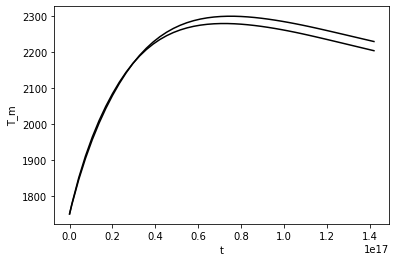

In [6]:
# how much does D_l affect flux?
plargs = dict(Alb=None, 
                             H_0=4e-12, # final radiogenic heating in W/kg
                             X_K=305, # initial abundance of K in wt ppm
                             X_U=16e-3, # initial abundane of U in wt ppm 
                             X_Th=56e-3, # initial abundance of Th in wt ppm 
                             L=None, 
                             Ra_crit_u=450, 
                             R_p0=3400e3, 
                             R_c0=1700e3,
                             alpha_m=2.5e-5, # thermal expansivity
                             k_m=4, # silicate thermal conductivity
                             CMF=0.24, # not used
                             rho_c=7200, # core density
                             rho_m=3500, # mantle density 
                             rho_lith=None, 
                             c_m=1142, #<----??? TODO: check if you need constant volume c_p
                             c_c=840, # specific heat for core in J/K/kg
                             k_lm=4, # thermal conduvtivity lower mantle
                             beta_u=None, # defaults to 1/3
                             beta_c=None, # defaults to 1/3 
                             a_rh=2.44, # for beta=1/3 
                             Ea=300e3, # activation energy in J for viscosity law
                             eta_0=1e21, # reference dynamic viscosity in Pa s
                             T_ref=1600, # viscosity law reference temperature in K
                             T_s=250, # fixed surface temp in K
                             M_p=6.39e23, # only used for gravity in this case
                             sma=None, 
                             ident='Mars1')

# constant D_l planet
Mars1_300 = tp.TerrestrialPlanet(D_l_const=100e3, **plargs)
model_args = dict(T_m0=1750, T_c0=2250, D_l0=300e3, tf=4.5, visc_type='KW', 
                  complexity=3) # model params
Mars1_300 = therm.solve(Mars1_300, **model_args) # T_m, T_c, D_l
Mars1_300.dyn_top_rms = top.dyn_topo(Mars1_300)
Mars1_300.sigma_interior = top.convective_stress(Mars1_300, where='interior')

# normal planet
Mars1 = tp.TerrestrialPlanet(**plargs)
model_args = dict(T_m0=1750, T_c0=2250, D_l0=300e3, tf=4.5, visc_type='KW', 
              complexity=3) # model params
Mars1 = therm.solve(Mars1, **model_args) # T_m, T_c, D_l
Mars1.dyn_top_rms = top.dyn_topo(Mars1)
Mars1.sigma_interior = top.convective_stress(Mars1, where='interior')

# plt.plot(Mars1_300.T_m, Mars1_300.q_ubl, 'b')
# plt.plot(Mars1.T_m, Mars1.q_ubl, 'r')
plt.plot(Mars1.t, Mars1.T_m, 'k', label='T_m')
plt.plot(Mars1_300.t, Mars1_300.T_m, 'k', label='T_m')
plt.xlabel('t')
plt.ylabel('T_m')
# plt.plot(np.linspace(0, 0.03), np.linspace(0, 0.03))
# plt.plot(np.linspace(0, 2300), np.linspace(0, 2300))

In [ ]:
# if you plug in q_

a_rh 2.44
T_m 1750.0 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2000.0 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 38922.66632135647
k_m 4
k_m 4
a_rh 2.44
T_m 1750.0 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2000.0 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 38922.66632135647
k_m 4
k_m 4
a_rh 2.44
T_m 1750.0 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2000.0 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 38922.66632135647
k_m 4
k_m 4
a_rh 2.44
T_m 1750.0 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2000.0 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 38922.66632135647
k_m 4
k_m 4
a_rh 2.44
T_m 1750.0 Ea 300000.0 mu 80000000000.0 A_rh 870000000

a_rh 2.44
T_m 1750.0000315262355 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2000.0000008486722 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 38922.68805300238
k_m 4
k_m 4
a_rh 2.44
T_m 1750.0000350291502 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2000.000000942969 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 38922.69046766061
k_m 4
k_m 4
a_rh 2.44
T_m 1750.0000350291502 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2000.000000942969 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 38922.69046766061
k_m 4
k_m 4
a_rh 2.44
T_m 1750.0000980816146 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2000.0000026403136 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 

T_m 2126.698750273338 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 2138989.83136239
k_m 4
k_m 4
a_rh 2.44
T_m 2159.6640513754073 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2128.288877531206 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 2175791.9685288095
k_m 4
k_m 4
a_rh 2.44
T_m 2172.314735211529 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2136.19525108463 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 2365138.0164715033
k_m 4
k_m 4
a_rh 2.44
T_m 2174.5125131972286 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2137.554837872518 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 2398888.916657442
k_m 4
k_m 4
a_rh 2.44
T_m 2177.17579157146 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 

a_rh 2.44
T_m 2304.8908715955904 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2275.6859919014946 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 8057583.287782782
k_m 4
k_m 4
a_rh 2.44
T_m 2305.156319069031 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2277.4989036039588 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 8158280.03649813
k_m 4
k_m 4
a_rh 2.44
T_m 2305.192075749457 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2277.804376473863 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 8175160.105690875
k_m 4
k_m 4
a_rh 2.44
T_m 2305.2182042955415 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2278.1704526062895 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 81

a_rh 2.44
T_m 2267.347991017709 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2272.663566512438 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 7281660.939263833
k_m 4
k_m 4
a_rh 2.44
T_m 2266.8612645848443 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2272.3786159580322 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 7260273.803047192
k_m 4
k_m 4
a_rh 2.44
T_m 2266.859751259715 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2272.376290474779 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 7260149.078283671
k_m 4
k_m 4
a_rh 2.44
T_m 2265.9829177054426 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
T_m 2271.861474172889 Ea 300000.0 mu 80000000000.0 A_rh 8700000000000000.0 h_rh 0.01 B_rh 5e-10 m_rh 2.5
Ra_rh 722

max qbl at T= [2303.05954552]
max qbl/qsfc at T= [2296.5609272]


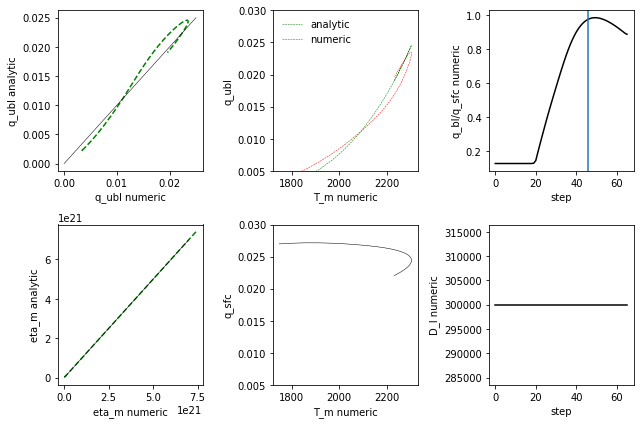

In [5]:
# compare analytic and numerical
plargs = dict(Alb=None, 
                             H_0=4e-12, # final radiogenic heating in W/kg
                             X_K=305, # initial abundance of K in wt ppm
                             X_U=16e-3, # initial abundane of U in wt ppm 
                             X_Th=56e-3, # initial abundance of Th in wt ppm 
                             L=None, 
                             Ra_crit_u=450, 
                             R_p0=3400e3, 
                             R_c0=1700e3,
                             alpha_m=2.5e-5, # thermal expansivity
                             k_m=4, # silicate thermal conductivity
                             CMF=0.24, # not used
                             rho_c=7200, # core density
                             rho_m=3500, # mantle density 
                             rho_lith=None, 
                             c_m=1142, #<----??? TODO: check if you need constant volume c_p
                             c_c=840, # specific heat for core in J/K/kg
                             k_lm=4, # thermal conduvtivity lower mantle
                             beta_u=None, # defaults to 1/3
                             beta_c=None, # defaults to 1/3 
                             a_rh=2.44, # for beta=1/3 
                             Ea=300e3, # activation energy in J for viscosity law
                             eta_0=1e21, # reference dynamic viscosity in Pa s
                             T_ref=1600, # viscosity law reference temperature in K
                             T_s=250, # fixed surface temp in K
                             M_p=6.39e23, # only used for gravity in this case
                             sma=None, 
                             ident='Mars1')
Mars1 = tp.TerrestrialPlanet(**plargs)
model_args = dict(T_m0=1750, T_c0=2250, D_l0=300e3, tf=4.5, visc_type='KW', 
              complexity=2) # model params
Mars1 = therm.solve(Mars1, **model_args) # T_m, T_c, D_l


Mars1_anal = tp.TerrestrialPlanet(**plargs)
Mars1_anal.init_derived( **plargs)
Mars1_anal.eta_m = rh.eta_KW(Mars1.T_m, pl=Mars1_anal)
Mars1_anal.q_ubl = q_bl_analytic(T_m=Mars1.T_m, pl=Mars1_anal, **plargs)


T_m = Mars1.T_m
q_ubl = Mars1.q_ubl
ratio = q_ubl/Mars1.q_sfc
i_max = np.where(q_ubl==np.max(q_ubl))[0][0]


fig, axes = plt.subplots(2, 3, figsize=(9,6))
ax = axes[0][0]
ax.plot(Mars1.q_ubl, Mars1_anal.q_ubl, 'g--') # not the same clearly
ax.plot(np.linspace(0, 0.025), np.linspace(0, 0.025), 'k', lw=0.5)
ax.set_xlabel('q_ubl numeric')
ax.set_ylabel('q_ubl analytic')

ax = axes[1][0]
ax.plot(Mars1.eta_m, Mars1_anal.eta_m, 'g--')
ax.set_xlabel('eta_m numeric')
ax.set_ylabel('eta_m analytic')
ax.plot(np.linspace(0, 7e21), np.linspace(0, 7e21), 'k', lw=0.5)

ax = axes[0][1]
ax.plot(Mars1.T_m, Mars1_anal.q_ubl, 'g--', lw=0.5, label='analytic') # backtrack because temp not monotonically increase
ax.plot(Mars1.T_m, Mars1.q_ubl, 'r--', lw=0.5, label='numeric')
ax.set_xlabel('T_m numeric')
ax.set_ylabel('q_ubl')
ax.legend(frameon=False)
ax.set_ylim(0.005, 0.03)

ax = axes[1][1]
ax.plot(Mars1.T_m, Mars1.q_sfc, 'k', lw=0.5, label='numeric')
ax.set_xlabel('T_m numeric')
ax.set_ylabel('q_sfc')
ax.set_ylim(0.005, 0.03)


ax = axes[0][2]
ax.plot(Mars1.q_ubl/Mars1.q_sfc, 'k')
ax.axvline(i_max)
ax.set_xlabel('step')
ax.set_ylabel('q_bl/q_sfc numeric')

ax = axes[1][2]
ax.plot(Mars1.D_l, 'k')
ax.set_xlabel('step')
ax.set_ylabel('D_l numeric')

plt.tight_layout()


print('max qbl at T=',T_m[np.where(q_ubl==np.max(q_ubl))])
print('max qbl/qsfc at T=',T_m[np.where(ratio==np.max(ratio))])



In [22]:
# plot dT/dq

i_max 46


Text(0, 0.5, 'D_l')

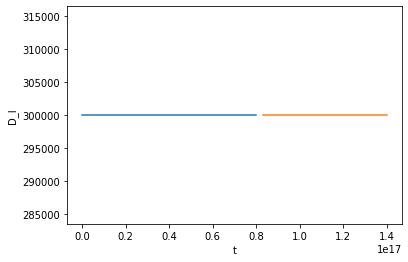

In [23]:
# compare lid thickesses between right and left of local maximum in q
t = Mars1.t
i_max = np.where(q_ubl==np.max(q_ubl))[0][0]
print('i_max', i_max)
plt.plot(t[0:i_max], Mars1.D_l[0:i_max], label='left')
plt.plot(t[i_max:-1], Mars1.D_l[i_max:-1], label='right')
plt.xlabel('t')
plt.ylabel('D_l')

# on the way down, q_ubl is higher for the same T_m, while q_sfc is lower... 
# meanwhile the system wants to maintain a steady state conduction in the lid (q_sfc/q_bl flattens)
# to make up for declining heat loss out of the top, the system wants to push more heat into the lid...? 
# max heating into lid when lid is thinnest, but there's a bit of a lag due to the lid not changing instantly so for the same T_m you don't get the same flux, not symmetric

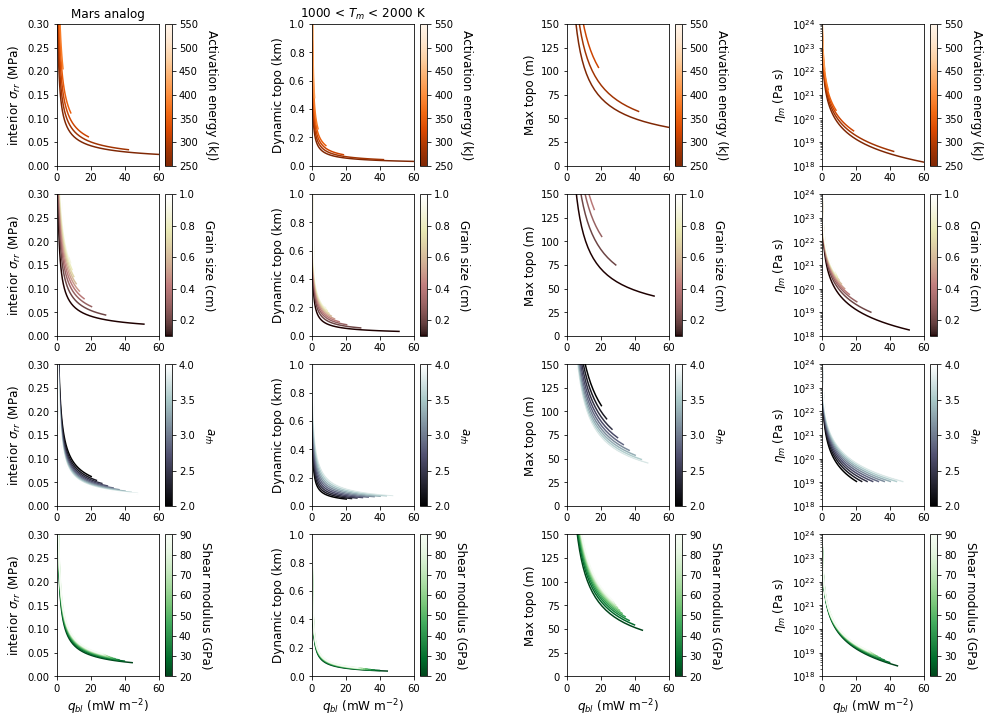

In [18]:
# how much does changing rheology change stresses?

z = {
     'Ea':('Activation energy (kJ)', 1e-3), 
     'h_rh':('Grain size (cm)', 1e2),
     'a_rh':('$a_{rh}$', 1), #'A_rh':('Pre-exponential factor (s$^{-1}$)', 1),
     'mu':('Shear modulus (GPa)', 1e-9)
    }
y = {
     'top.convective_stress':('interior $\sigma_{rr}$ (MPa)', 1e-6),
     'top.dyn_topo':('Dynamic topo (km)',1e-3),
     'top.max_topo':('Max topo (m)', 1),
     'rh.eta_KW':('$\eta_m$ (Pa s)',1),
    }
ylims = ([0, 0.3], [0, 1], [0, 150], [1e18, 1e24])
zlims = ((250e3, 550e3), (1e-3, 1e-2), (2, 4), (20e9, 90e9))
cmap = ['Oranges_r', 'pink', 'bone', 'Greens_r']

defaults_Mars = dict(rho_m=3500, alpha_m=2e-5, kappa_m=9.6e-7, g_sfc=3.7, k_m=4, 
                     Ea=300e3,  where='mantle', mu=80e9, A_rh=8.7e15, 
                     h_rh=2.07e-3, B_rh=0.5e-9, m_rh=2.5, a_rh=2.54)
# a_rh = 3.4 for Reese+

fig = analytical_tradeoff_subplots(z=z, y=y, cmap=cmap, ylims=ylims, zlims=zlims, defaults=defaults_Mars, 
                                   res=10,T_min=1000, T_max=2000, suptitle='Mars analog', 
                                  # xlim=[1, 50] #
#                                    xlim=[19, 35]
                                  )
fig.savefig(fig_path+'tradeoffs.pdf', bbox_inches='tight')
# doesn't capture the effect of grain growth
# why is stress so low now?

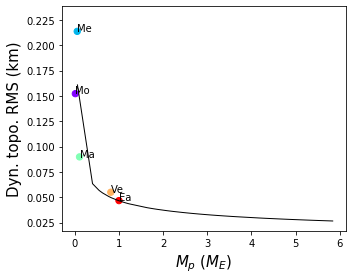

In [13]:
##### plot final evolution on single mass axis ######
# planets = build_solarsystem()

# TODO: add datapoints from literature on SS


ynames = {'dyn_top_rms':('Dyn. topo. RMS (km)', 1e-3)}
xname = {'M_p':('$M_p$ ($M_E$)', p.M_E**-1)}
defaults = {'Ra_crit_u':450, 'c_m':1142, 'k_lm':4, 'a_rh':2.54, 'alpha_m':2.5e-5}
moreplanets = bulk_planets(N=50, name='M_p', mini=0.05*p.M_E, maxi=6*p.M_E, **defaults)
fig, axes = plot_vs_x(scplanets=planets, lplanets=moreplanets, xname=xname, ynames=ynames, 
                      labels=True, s=40, plots_save=False)

# data
 # Solomatov 

h = 2.0721961953453367 mm


/home/claire/Works/exo-top/thermal.py:88: RuntimeWarning: invalid value encountered in double_scalars
  return (R_l - R_c) * (Ra_crit/Ra_rh)**beta
/home/claire/Works/exo-top/thermal.py:223: RuntimeWarning: invalid value encountered in double_scalars
  pl.Ra_crit_c = 0.28*pl.Ra_i**0.21


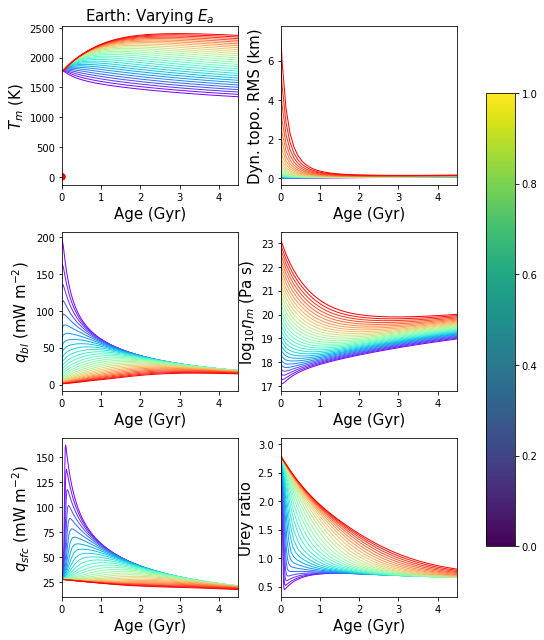

In [8]:
######  test effect of changing reference viscosity on Earth
names = {'T_m':('$T_m$ (K)',1), 
         'dyn_top_rms':('Dyn. topo. RMS (km)', 1e-3),
         'q_ubl':('$q_{bl}$ (mW m$^{-2}$)',1e3), 
         'eta_m':('$\log_{10} \eta_m$ (Pa s)',1), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'urey':('Urey ratio',1),
        }
save = False


h = rh.grain_size(A_rh=8.7e15, eta_0=1e21, Ea=300e3, T_ref=1600, m=2.5, B_rh=0.5e-9, mu=80e9)
print('h =',h*1e3, 'mm')

defaults = dict(
     Alb=None, 
     H_0=4e-12, # final radiogenic heating in W/kg
     X_K=305, # initial abundance of K in wt ppm
     X_U=16e-3, # initial abundane of U in wt ppm 
     X_Th=56e-3, # initial abundance of Th in wt ppm 
     L=None, 
     Ra_crit_u=450, 
     R_p0=3400e3, 
     R_c0=1700e3,
     alpha_m=2.5e-5, # thermal expansivity
     k_m=4, # silicate thermal conductivity
     CMF=0.24, # not used
     rho_c=7200, # core density
     rho_m=3500, # mantle density 
     rho_lith=None, 
     c_m=1142, #<----??? TODO: check if you need constant volume c_p
     c_c=840, # specific heat for core in J/K/kg
     k_lm=4, # thermal conduvtivity lower mantle
     beta_u=None, # defaults to 1/3
     beta_c=None, # defaults to 1/3 
     a_rh=2.44, # for beta=1/3 
#      Ea=300e3, # activation energy in J for viscosity law
     T_s=250, # fixed surface temp in K
     M_p=6.39e23, # only used for gravity in this case
     sma=None, 
     g_sfc = 3.7,
    mu=80e9, A_rh=8.7e15, h_rh=2.07e-3, B_rh=0.5e-9, m_rh=2.5
     )
kwargs = dict(T_m0=1750, T_c0=2250, D_l0=300e3, t0=0, tf=4.5, visc_type='KW', complexity=3) # model params
Ea_vec = np.linspace(200e3, 400e3, num=30)
cols = colorize(Ea_vec, cmap='rainbow')[0]
for ii, Ea in enumerate(Ea_vec):
    pl = tp.TerrestrialPlanet(Ea=Ea, **defaults)
    pl = therm.solve(pl, **kwargs) # T_m, T_c, D_l
    pl.dyn_top_rms = top.dyn_topo(pl=pl, C=5.4, **kwargs)
    if ii==0:
        fig=None
        axes=None
    fig, axes = plot_output(pl, names, ncols=2, plots_save=save, fig=fig, axes=axes, col=cols[ii],
#                             label='%d kJ'%(Ea*1e-3), 
                            verbose=False, fig_path=fig_path, legend=False,
                            title='Earth: Varying $E_a$', **kwargs)

sc = axes[0][0].scatter([0]*len(cols), [0]*len(cols), c=cols, cmap='rainbow', vmin=Ea_vec.min(), vmax=Ea_vec.max())    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc, cax=cbar_ax)
sc.set_visible=False
# plt.tight_layout()    
    

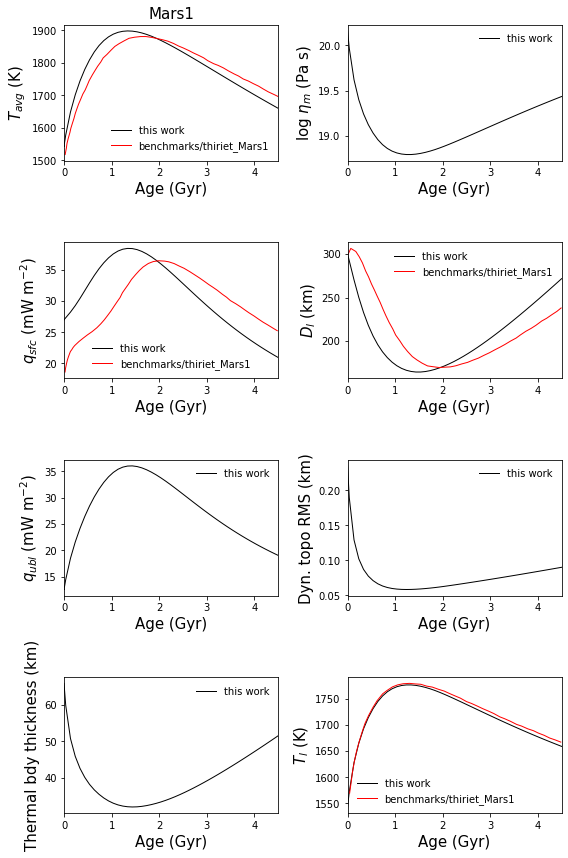

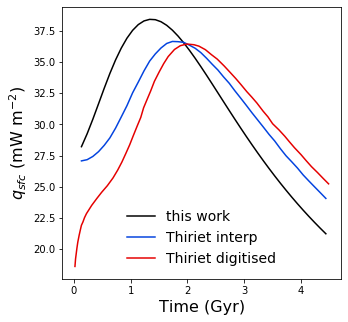

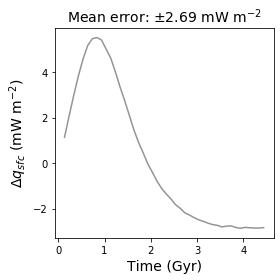

In [14]:
######  reproduce Thiriet+ 2019 Mars1

Mars1 = tp.TerrestrialPlanet(h_rh=2.07e-3, 
                             Alb=None, 
                             H_0=4e-12, # final radiogenic heating in W/kg
                             X_K=305, # initial abundance of K in wt ppm
                             X_U=16e-3, # initial abundane of U in wt ppm 
                             X_Th=56e-3, # initial abundance of Th in wt ppm 
                             L=None, 
                             Ra_crit_u=450, 
                             R_p0=3400e3, 
                             R_c0=1700e3,
                             alpha_m=2.5e-5, # thermal expansivity
                             k_m=4, # silicate thermal conductivity
                             CMF=0.24, # not used
                             rho_c=7200, # core density
                             rho_m=3500, # mantle density 
                             rho_lith=None, 
                             c_m=1142, #<----??? TODO: check if you need constant volume c_p
                             c_c=840, # specific heat for core in J/K/kg
                             k_lm=4, # thermal conduvtivity lower mantle
                             beta_u=None, # defaults to 1/3
                             beta_c=None, # defaults to 1/3 
                             a_rh=2.44, # for beta=1/3 
                             Ea=300e3, # activation energy in J for viscosity law
                             eta_0=1e21, # reference dynamic viscosity in Pa s
                             T_ref=1600, # viscosity law reference temperature in K
                             T_s=250, # fixed surface temp in K
                             M_p=6.39e23, # only used for gravity in this case
                             sma=None, 
                             ident='Mars1'
                             )
kwargs = dict(T_m0=1750, T_c0=2250, D_l0=300e3, tf=4.5, visc_type='KW', 
              complexity=3) # model params
Mars1 = therm.solve(Mars1, **kwargs) # T_m, T_c, D_l
Mars1.dyn_top_rms = top.dyn_topo(Mars1)
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('log $\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'q_ubl':('$q_{ubl}$ (mW m$^{-2}$)', 1e3), #'urey':('Urey ratio',1),
         'dyn_top_rms':('Dyn. topo RMS (km)',1e-3), 
         'TBL_u':('Thermal bdy thickness (km)',1e-3), 
         'T_l':('$T_l$ (K)',1), 
        }
save = True
# snaps(Mars1_complex3, plot_snapshots=[0, 2, 4.5], fig_path=fig_path, plots_save=save, **kwargs)
fig, axes = plot_output(Mars1, names, ncols=2, plots_save=save, verbose=False, 
                        compare_dir='benchmarks/thiriet_Mars1',fig_path=fig_path, **kwargs)
plot_qsfc_error(Mars1, compare_dir='benchmarks/thiriet_Mars1', fig_path=fig_path, plots_save=save, 
                ident='Mars1', **kwargs)
# plot_Tavg(Mars1_complex3, compare_dir='benchmarks/thiriet_Mars1', plots_save=save, 
#           fig_path=fig_path, **kwargs)

# expect q_sfc to be off by <=4.5 mW m^-3 average without PDE

In [7]:
######  reproduce Thiriet+ 2019 Moon1
Moon1 = tp.TerrestrialPlanet(M_p = 7.34767309e22,
                            R_p0 = 1740e3,
                            R_c0 = 390e3,
                            Ra_crit_u = 450,
                            rho_m = 3300,
                            rho_c = 7200,
                            c_m = 1142,
                            c_c = 840,
                            beta_u = 0.346, # defaults to 1/3
                            beta_c = None, # defaults to 1/3
                            a_rh = 2.44,
                            k_m = 4,
                            k_lm = 4,
                            alpha_m = 2.5e-5,
                            T_s = 250,
                            Ea = 300e3,
                            eta_0 = 1e21,
                            T_ref = 1600,
                            X_K = 83, # initial abundance of K in wt ppm 
                            X_U = 33e-3, # initial abundane of U in wt ppm 
                            X_Th = 125e-3, # initial abundance of Th in wt ppm 
                            H_0 = 7e-12, # radiogenic heating in W/kg at t_f
                            ident = 'Moon1'
                            )
kwargs = dict(T_m0=1750, T_c0=2000, D_l0=445e3, t0=0, tf=4.5, visc_type='Thi', complexity=3) # model params
Moon1 = therm.solve(Moon1, **kwargs)
pl = Moon1
pl.dyn_top_rms = top.dyn_topo(pl)
#top.dyn_topo(pl.q_sfc, rho_m=pl.rho_m, rho_w=0, alpha_m=pl.alpha_m, eta_m=pl.eta_m,
#                               kappa_m=pl.kappa_m, g_sfc=pl.g_sfc, k_m=pl.k_m, C=5.4, **kwargs)

names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'urey':('Urey ratio',1),
         'dyn_top_rms':('Dyn. topo RMS (km)',1e-3), 
        }
save=True
# snaps(f_Moon1, plot_snapshots=[0, 1, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
# plot_output(Moon1, names, ncols=2, plots_save=save, compare_dir='benchmarks/thiriet_Moon1', 
#             fig_path=fig_path, tspan=(0, 4.5), **kwargs)


In [8]:
######  reproduce Thiriet+ 2019 Mercury1
Mercury1 = tp.TerrestrialPlanet(M_p = 3.285e23,
                                R_p0 = 2440e3,
                                R_c0 = 2010e3,
                                Ra_crit_u = 450,
                                rho_m = 3500,
                                rho_c = 7200,
                                c_m = 1142,
                                c_c = 840,
                                beta_u = 0.335, # defaults to 1/3
                                beta_c = None, # defaults to 1/3
                                a_rh = 2.54, 
                                k_m = 4,
                                k_lm = 4,
                                alpha_m = 2.5e-5,
                                T_s = 440,
                                # viscosity 
                                Ea = 300e3,
                                eta_0 = 1e21,
                                T_ref = 1600,
                                X_K = 400, # initial abundance of K in wt ppm 
                                X_U = 28e-3, # initial abundane of U in wt ppm 
                                X_Th = 50e-3, # initial abundance of Th in wt ppm 
                                H_0 = 5e-12, # radiogenic heating in W/kg at t_f
                                ident='Mercury1'
                            )
kwargs = dict(T_m0=1750, T_c0=2000, D_l0=137e3, t0=0, tf=4.5, visc_type='Thi', complexity=3) # model params
Mercury1 = therm.solve(Mercury1, **kwargs)
pl = Mercury1
pl.dyn_top_rms = top.dyn_topo(pl)
#top.dyn_topo(pl.q_sfc, rho_m=pl.rho_m, rho_w=0, alpha_m=pl.alpha_m, eta_m=pl.eta_m,
#                               kappa_m=pl.kappa_m, g_sfc=pl.g_sfc, k_m=pl.k_m, C=5.4, **kwargs)
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'urey':('Urey ratio',1),
         'dyn_top_rms':('Dyn. topo RMS (km)',1e-3), 
        }
save=True
# snaps(Mercury1, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
# plot_output(Mercury1, names, tspan=(0, 2), ncols=2, plots_save=save, fig_path=fig_path,
#             compare_dir='benchmarks/thiriet_Mercury1', **kwargs)


In [9]:
######  extrapolate Thiriet+ 2019 to Venus
Venus = tp.TerrestrialPlanet(M_p = 4.867e24,
                                R_p0 = 6051.8e3,
                                R_c0 = 2900e3,
                                Ra_crit_u = 450,
                                rho_m = 3500,
                                rho_c = 7200,
                                c_m = 1142,
                                c_c = 840,
                                beta_u = 0.335, # defaults to 1/3
                                beta_c = None, # defaults to 1/3
                                a_rh = 2.54 ,
                                k_m = 4,
                                k_lm = 4,
                                alpha_m = 2.5e-5,
                                T_s = 467+273,
                                # viscosity 
                                Ea = 300e3,
                                eta_0 = 1e21,
                                T_ref = 1600,
                                H_0 = 4.6e-12, # radiogenic heating in W/kg at 4.5 Gyr from Javoy (1999) BSE estimate from CI chondrites
                                ident = 'Venus',
                            )                   
kwargs = dict(T_m0 = 1750,T_c0 = 2250,D_l0 = 600e3,t0=0, tf=4.5, visc_type='Thi', complexity=3)
Venus = therm.solve(Venus, **kwargs)
pl = Venus
pl.dyn_top_rms = top.dyn_topo(pl)
#top.dyn_topo(pl.q_sfc, rho_m=pl.rho_m, rho_w=0, alpha_m=pl.alpha_m, eta_m=pl.eta_m,
#                               kappa_m=pl.kappa_m, g_sfc=pl.g_sfc, k_m=pl.k_m, C=5.4, **kwargs)
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'urey':('Urey ratio',1),
         'dyn_top_rms':('Dyn. topo RMS (km)',1e-3), 
        }
save=True
# snaps(Venus, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
# plot_output(Venus, names, ncols=2, plots_save=save, fig_path=fig_path, **kwargs)
# plot_qsfc_error(Venus, fig_path=fig_path, plots_save=save,
#                 ident=ident, **kwargs)


In [10]:
######  extrapolate Thiriet+ 2019 to Earth
Earth = tp.TerrestrialPlanet(M_p = p.M_E, 
                            CMF = 0.3,
                            sma = 1,
                            L=1,
                            Alb=0,
                            Ra_crit_u = 450,
                            rho_m = 3500,
                            rho_c = 7200,
                            c_m = 1142,
                            c_c = 840,
                            beta_u = 0.335, # defaults to 1/3
                            beta_c = None, # defaults to 1/3
                            a_rh = 2.54 ,
                            k_m = 4,
                            k_lm = 4,
                            alpha_m = 2.5e-5,
                            # viscosity 
                            Ea = 300e3,
                            eta_0 = 1e21,
                            T_ref = 1600,
                            H_0 = 4.6e-12, # radiogenic heating in W/kg at 4.5 Gyr from Javoy (1999) BSE estimate from CI chondrites
                            ident = 'Earth'
                            )                  
kwargs = dict(T_m0=1750, T_c0=2250, D_l0=600e3, t0=0, tf=4.5, visc_type='Thi', complexity=3)
Earth = therm.solve(Earth, **kwargs)
pl = Earth
pl.dyn_top_rms = top.dyn_topo(pl)
#top.dyn_topo(pl.q_sfc, rho_m=pl.rho_m, rho_w=0, alpha_m=pl.alpha_m, eta_m=pl.eta_m,
#                               kappa_m=pl.kappa_m, g_sfc=pl.g_sfc, k_m=pl.k_m, C=5.4, **kwargs)
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'D_l':('$D_l$ (km)',1e-3),
         'urey':('Urey ratio',1),
         'dyn_top_rms':('Dyn. topo RMS (km)',1e-3), 
        }
save=True
# snaps(Earth, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, **kwargs)
# plot_output(Earth, names, ncols=2, plots_save=save, fig_path=fig_path,
#             **kwargs)


In [ ]:
###### reproduce Nimmo & McKenzie 1997 

T_m0 = 3000 # initial mantle temp in K
T_c0 = 3000 # initial core temp in K
M_p = 1 # M_E
CMF = 0.3
t_f = 4 # Gyr
nu_m=5.5e15
rho_m=4800
alpha_m = 4e-5
k_m = 3.11
k_lm = 3.11
beta = 0.25
T_s = 450+273
visc_type='constant'


In [ ]:
###### reproduce Kite+ 2009 stagnant lid model (melting?) 

alpha_m = 3e-5
k_m = 4.18
c_pm = 914
rho_m = 3400
CMF = 0.325
T_m0 = 3273

In [ ]:
###### reproduce Venus fig 6 in Driscoll & Bercovici FAILED 
alpha_m = 3e-5
c_pm = 1265
k_m = 4.2
k_lm = 10
rho_m = 4800
M_p = 1 #4.867e24/M_E # M_E
CMF = 0.3
t_f = 4 # Gyr
T_m0 = 2510 # initial mantle temp in K
T_s = 737


In [219]:
# check radiogenic heating rates

c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, 56/16, 305e3/16])
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5]
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec
tf = 4.5e9*years2sec
h_0 = h_rad(0, tf, 4e-12, c_n, p_n, lambda_n)
h_f = h_rad(4.5e9*years2sec, tf, 4e-12, c_n, p_n, lambda_n)
print('H_t0 =', h_0, 'W/kg =', h_0*6.39e23*1e-11, 'TW')
print('H_tf =', h_f, 'W/kg =', h_f*6.39e23*1e-11, 'TW')

H_t0 = 2.217642585962431e-11 W/kg = 141.70736124299933 TW
H_tf = 4e-12 W/kg = 25.56 TW


In [ ]:
# # possible variables to plot
# names={'T_m':('$T_m$ (K)', 1), 
#        'T_c':('$T_c$ (K)', 1), 
#        'D_l':('$D_l$ (km)', 1e-3), 
#        'eta_m':('$\eta_m$ (Pa s)', 1), 
#        'eta_cmb':('$\eta_{cmb}$ (Pa s)', 1), 
#        'TBL_u':('$TBL_u$ (km)', 1e-3),
#        'TBL_c':('$TBL_c$ (km)', 1e-3), 
#        'h_rad_m':('$h_{rad,m}$ (pW kg$^{-1}$)', 1e12), 
#        'H_rad_m':('$H_{rad,m}$ (TW)', 1e-12), 
#        'q_ubl':('$q_{ubl}$ (mW m$^{-2}$)', 1e3), 
#        'M_mi':('$M_{mantle}$ (kg)', 1),
#        'Q_ubl':('$Q_{ubl}$ (TW)', 1e-12),
#        'Q_core':('$Q_{core}$ (TW)', 1e-12), 
#        'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)', 1e3), 
#        'Q_sfc':('$Q_{sfc}$ (TW)', 1e-12),
#        'q_core':('$q_{core}$ (mW m$^{-2}$)', 1e3), 
#        'urey':('Urey ratio', 1), 
#        'Ra_i':('Ra$_i$', 1)
#       } # format variable_name:(ylabel, scale)

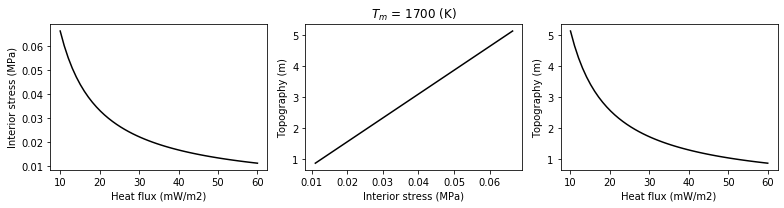

In [27]:
# plot lid stress
q_bl = np.linspace(10e-3, 60e-3)
T_m = 1700
def lid_stress(T_m=1600, eta_0=1e21, Ea=300e3, R_b=p.R_b, rho_m=3500, g_sfc=9.8, 
                  k_m=4, alpha_m=2e-5, kappa_m=9.5e-7, q_bl=20e-3):
    return 2.2*rho_m*alpha_m*g_sfc*(R_b*T_m**2/Ea)**2*k_m/q_bl

def int_stress(T_m=1600, eta_0=1e21, Ea=300e3, R_b=p.R_b, rho_m=3500, g_sfc=9.8, 
                  k_m=4, alpha_m=2e-5, kappa_m=9.5e-7, q_bl=20e-3):
    return 0.1*rho_m*alpha_m*g_sfc*(R_b*T_m**2/Ea)**2*k_m/q_bl

def stress_height(s=0.1e3, rho_m=3500, rho_w=0, g_sfc=9.8):
    delta_rho = rho_m - rho_w
    return s/(delta_rho*g_sfc)

fig, axes = plt.subplots(1, 3, figsize=(11, 3))
s = int_stress(q_bl=q_bl, g_sfc=3.7, T_m=T_m)
h = stress_height(s=s, g_sfc=3.7)

axes[0].plot(q_bl*1e3, s*1e-6, 'k')
axes[0].set_xlabel('Heat flux (mW/m2)')
axes[0].set_ylabel('Interior stress (MPa)')

axes[1].plot(s*1e-6, h, 'k')
axes[1].set_xlabel('Interior stress (MPa)')
axes[1].set_ylabel('Topography (m)')

axes[2].plot(q_bl*1e3, h, 'k')
axes[2].set_xlabel('Heat flux (mW/m2)')
axes[2].set_ylabel('Topography (m)')

axes[1].set_title('$T_m$ = '+str(T_m)+' (K)')
plt.tight_layout()
fig.savefig('flux-stress-height.png', bbox_inches='tight')

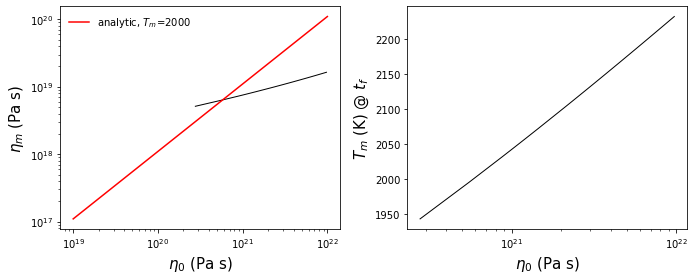

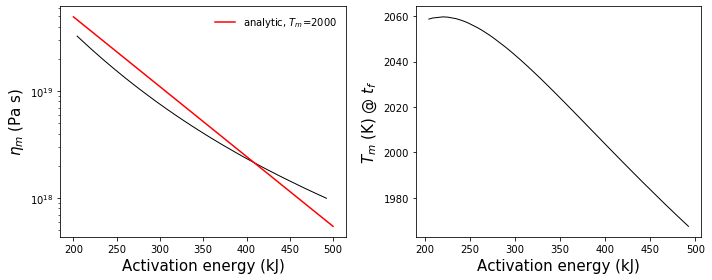

In [30]:
##### plot visc tradeoffs ######

# planets = build_solarsystem()
defaults = {'Ra_crit_u':450, 'c_m': 1142, 'k_lm':4, 'a_rh':2.54, 'alpha_m':2.5e-5, 'T_ref':1600}
ynames = {'eta_m':('$\eta_m$ (Pa s)', 1), 'T_m':('$T_m$ (K) @ $t_f$', 1)}
save=False

xname = {'eta_0':('$\eta_0$ (Pa s)',1)}
planets_eta0 = bulk_planets(N=50, name='eta_0', mini=1e18, maxi=1e22, **defaults)
fig0, axes0 = plot_vs_x(lplanets=planets_eta0, xname=xname, ynames=ynames, 
                      s=40, plots_save=save)

xname = {'Ea':('Activation energy (kJ)', 1e-3)}
planets_Ea = bulk_planets(N=50, name='Ea', mini=200e3, maxi=500e3, **defaults)
fig1, axes1 = plot_vs_x(lplanets=planets_Ea, xname=xname, ynames=ynames, 
                      s=40, plots_save=save)

# compare to analytical
T_m = 2000
Ea = 300e3
eta_0 = np.logspace(19, 22, num=100)
eta_m = eta_0*np.exp(Ea/p.R_b * (T_m**-1 - defaults['T_ref']**-1))
axes0[0].plot(eta_0, eta_m, c='r', label='analytic, $T_m$='+str(T_m))
axes0[0].legend(frameon=False)
fig0.savefig('eta0_test.png', bbox_inches='tight')

eta_0 = 1e21
Ea = np.linspace(200, 500, num=100) # in kJ
eta_m = eta_0*np.exp(Ea*1e3/p.R_b*(1/T_m - 1/defaults['T_ref']))
axes1[0].plot(Ea, eta_m, c='r', label='analytic, $T_m$='+str(T_m))
axes1[0].legend(frameon=False)
fig0.savefig('Ea_test.png', bbox_inches='tight')

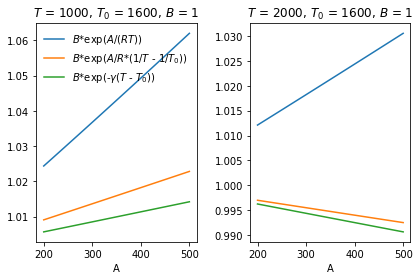

In [7]:
# regular arrhenius law
fig, axes = plt.subplots(1, 2)
B = 1
T = [1000, 2000]
T0 = 1600
A = np.linspace(200, 500, num=100) # in kJ
gamma = A/(p.R_b*T0**2)

for i, TT in enumerate(T):
    axes[i].plot(A, B*np.exp(A/(p.R_b*TT)), label='$B$*exp($A$/($RT$))')
    axes[i].plot(A, B*np.exp(A/p.R_b*(1/TT - 1/T0)), label='$B$*exp($A$/$R$*(1/$T$ - 1/$T_0$))') # difference
    axes[i].plot(A, B*np.exp(-gamma*(TT - T0)), label='$B$*exp(-$\gamma$($T$ - $T_0$))') # Frank-Kamenetskii
    axes[i].set_title('$T$ = '+str(TT)+', $T_0$ = 1600, $B$ = 1')
    axes[i].set_xlabel('A')
axes[0].legend(frameon=False)
plt.tight_layout()
plt.savefig('activation_energy.png', bbox_inches='tight')

Ea (22786.345773422203-402898.9062996133j)
eta0 2.1137706053129774e+23


/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/cmg76/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False

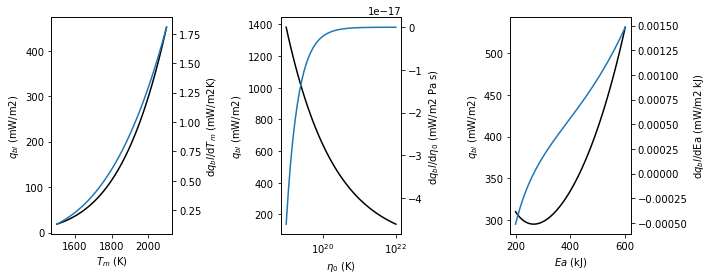

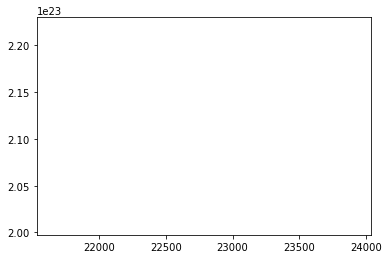

In [57]:
# analytic - derivatives

def dq_dT(T_m=2000, eta_0=1e21, Ea=300e3, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
                  k_m=4, alpha_m=2e-5, kappa_m=9.5e-7):
    return eta_0*k_m*kappa_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333*(0.333333333333333*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(eta_0*kappa_m) + 0.666666666666667*R_b*T_m*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))*np.exp(Ea*(1/T_m - 1/T_0)/R_b)/(alpha_m*g_sfc*rho_m) + 2*R_b*T_m*a_rh*k_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333/Ea

def dq_deta0(T_m=2000, eta_0=1e21, Ea=300e3, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
                  k_m=4, alpha_m=2e-5, kappa_m=9.5e-7):
    return -0.333333333333333*R_b*T_m**2*a_rh*k_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333/(Ea*eta_0)

def dq_dEa(T_m=2000, eta_0=1e21, Ea=300e3, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
           k_m=4, alpha_m=2e-5, kappa_m=9.5e-7):
    return eta_0*k_m*kappa_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333*(-0.333333333333333*T_m**2*a_rh*alpha_m*g_sfc*rho_m*(1/T_m - 1/T_0)*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m) - 0.333333333333333*R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea**2*eta_0*kappa_m))*np.exp(Ea*(1/T_m - 1/T_0)/R_b)/(alpha_m*g_sfc*rho_m) - R_b*T_m**2*a_rh*k_m*(R_b*T_m**2*a_rh*alpha_m*g_sfc*rho_m*np.exp(-Ea*(1/T_m - 1/T_0)/R_b)/(Ea*eta_0*kappa_m))**0.333333333333333/Ea**2

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
T_m = np.linspace(1500, 2100)
ax1=axes[0]
ax1.plot(T_m, q_bl_analytic(T_m=T_m)*1e3, 'k')
ax1.set_xlabel('$T_m$ (K)')
ax1.set_ylabel('$q_{bl}$ (mW/m2)')
ax2 = ax1.twinx()
ax2.plot(T_m, dq_dT(T_m=T_m)*1e3)
ax2.set_ylabel('d$q_bl$/d$T_m$ (mW/m2K)')

ax1=axes[1]
eta_0 = np.logspace(19, 22)
ax1.plot(eta_0, q_bl_analytic(eta_0=eta_0)*1e3, 'k')
ax1.set_xlabel('$\eta_0$ (K)')
ax1.set_ylabel('$q_{bl}$ (mW/m2)')
ax2 = ax1.twinx()
ax2.plot(eta_0, dq_deta0(eta_0=eta_0)*1e3)
ax2.set_ylabel('d$q_bl$/d$\eta_0$ (mW/m2 Pa s)')
ax1.set_xscale('log')
ax2.set_xscale('log')
plt.tight_layout()

ax1=axes[2]
Ea = np.linspace(200e3, 600e3)
ax1.plot(Ea*1e-3, q_bl_analytic(Ea=Ea)*1e3, 'k')
ax1.set_xlabel('$Ea$ (kJ)')
ax1.set_ylabel('$q_{bl}$ (mW/m2)')
ax2 = ax1.twinx()
ax2.plot(Ea*1e-3, dq_dEa(Ea=Ea)*1e3)
ax2.set_ylabel('d$q_bl$/dEa (mW/m2 kJ)')
plt.tight_layout()

# function of eta
def eta_0(T_m=2000, q_bl=100e-3, Ea=300e3, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
           k_m=4, alpha_m=2e-5, kappa_m=9.5e-7, eta_m=None):
    return R_b**4*T_m**8*a_rh**4*alpha_m*g_sfc*k_m**3*rho_m/(Ea**4*kappa_m*q_bl**3)
def Ea(T_m=2000, q_bl=100e-3, eta_0=1e21, R_b=p.R_b, a_rh=2.54, rho_m=3500, g_sfc=9.8, T_0=1600, 
           k_m=4, alpha_m=2e-5, kappa_m=9.5e-7, eta_m=None):
    return R_b**4*T_m**8*a_rh**4*alpha_m*g_sfc*k_m**3*rho_m/(Ea**4*kappa_m*q_bl**3)

eta_m = np.linspace(50e-3, 200e-3, num=10)
fig, ax = plt.subplots(1,1)
for i, q in enumerate(q_bl):
    ax.plot(Ea_test, eta0_test, c=cm.jet(norm(q)) )

# hold q_bl constant

